In [10]:
from Model import *

# Root directory for dataset
dataroot = r'C:\Users\prave\Downloads\HW2\prob 2\colored_squares'

In [11]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

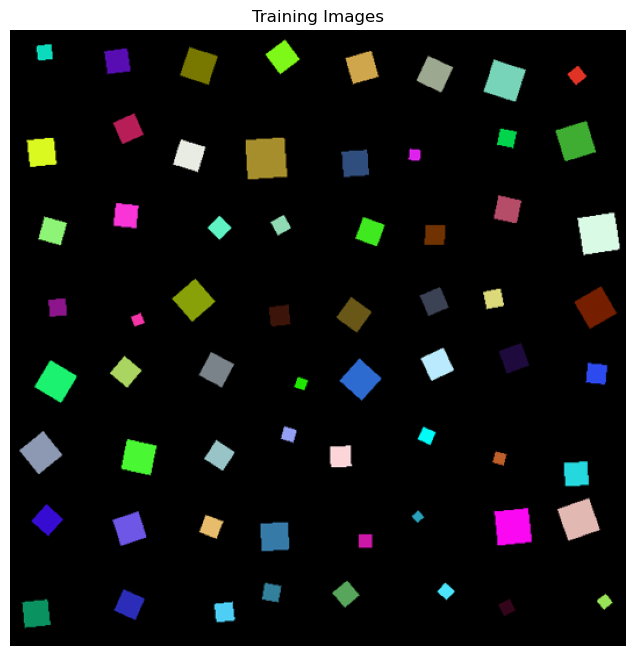

In [12]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [13]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)



# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)



# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs= 10

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/782]	Loss_D: 2.0190	Loss_G: 6.0067	D(x): 0.7255	D(G(z)): 0.7471 / 0.0040
[0/10][50/782]	Loss_D: 0.0841	Loss_G: 11.2738	D(x): 0.9520	D(G(z)): 0.0000 / 0.0000
[0/10][100/782]	Loss_D: 0.4523	Loss_G: 7.9627	D(x): 0.9280	D(G(z)): 0.2800 / 0.0008
[0/10][150/782]	Loss_D: 0.1135	Loss_G: 5.8102	D(x): 0.9768	D(G(z)): 0.0816 / 0.0036
[0/10][200/782]	Loss_D: 0.0363	Loss_G: 5.8925	D(x): 0.9904	D(G(z)): 0.0262 / 0.0031
[0/10][250/782]	Loss_D: 0.0132	Loss_G: 7.4566	D(x): 0.9978	D(G(z)): 0.0109 / 0.0009
[0/10][300/782]	Loss_D: 0.0101	Loss_G: 6.7623	D(x): 0.9984	D(G(z)): 0.0084 / 0.0019
[0/10][350/782]	Loss_D: 0.0060	Loss_G: 7.0704	D(x): 0.9973	D(G(z)): 0.0030 / 0.0010
[0/10][400/782]	Loss_D: 0.0108	Loss_G: 6.8018	D(x): 0.9938	D(G(z)): 0.0032 / 0.0012
[0/10][450/782]	Loss_D: 0.0040	Loss_G: 6.9703	D(x): 0.9990	D(G(z)): 0.0030 / 0.0010
[0/10][500/782]	Loss_D: 0.0067	Loss_G: 6.6865	D(x): 0.9983	D(G(z)): 0.0049 / 0.0016
[0/10][550/782]	Loss_D: 0.0023	Loss_G: 7.4565	D(x): 

[6/10][100/782]	Loss_D: 0.3682	Loss_G: 3.0812	D(x): 0.9694	D(G(z)): 0.2762 / 0.0547
[6/10][150/782]	Loss_D: 1.0959	Loss_G: 0.8767	D(x): 0.4152	D(G(z)): 0.0628 / 0.4381
[6/10][200/782]	Loss_D: 0.1000	Loss_G: 3.2765	D(x): 0.9471	D(G(z)): 0.0434 / 0.0449
[6/10][250/782]	Loss_D: 1.1313	Loss_G: 6.0784	D(x): 0.9799	D(G(z)): 0.6356 / 0.0034
[6/10][300/782]	Loss_D: 0.9933	Loss_G: 3.6733	D(x): 0.9753	D(G(z)): 0.5629 / 0.0368
[6/10][350/782]	Loss_D: 0.3144	Loss_G: 5.7627	D(x): 0.9898	D(G(z)): 0.2516 / 0.0039
[6/10][400/782]	Loss_D: 0.3063	Loss_G: 3.0072	D(x): 0.8839	D(G(z)): 0.1577 / 0.0595
[6/10][450/782]	Loss_D: 0.8266	Loss_G: 0.1273	D(x): 0.4710	D(G(z)): 0.0049 / 0.8891
[6/10][500/782]	Loss_D: 1.3635	Loss_G: 6.2091	D(x): 0.9927	D(G(z)): 0.7063 / 0.0025
[6/10][550/782]	Loss_D: 0.3100	Loss_G: 2.6361	D(x): 0.8411	D(G(z)): 0.1193 / 0.0891
[6/10][600/782]	Loss_D: 0.4764	Loss_G: 5.5943	D(x): 0.9779	D(G(z)): 0.3371 / 0.0050
[6/10][650/782]	Loss_D: 0.1398	Loss_G: 3.0552	D(x): 0.9227	D(G(z)): 0.0559 /

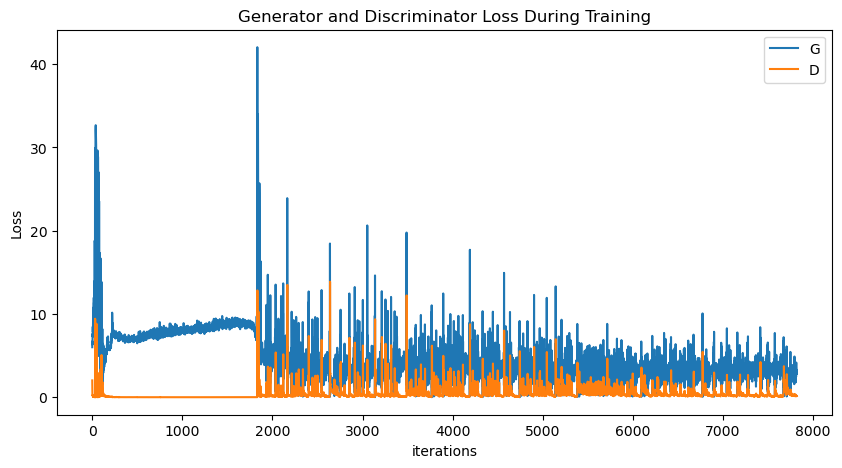

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

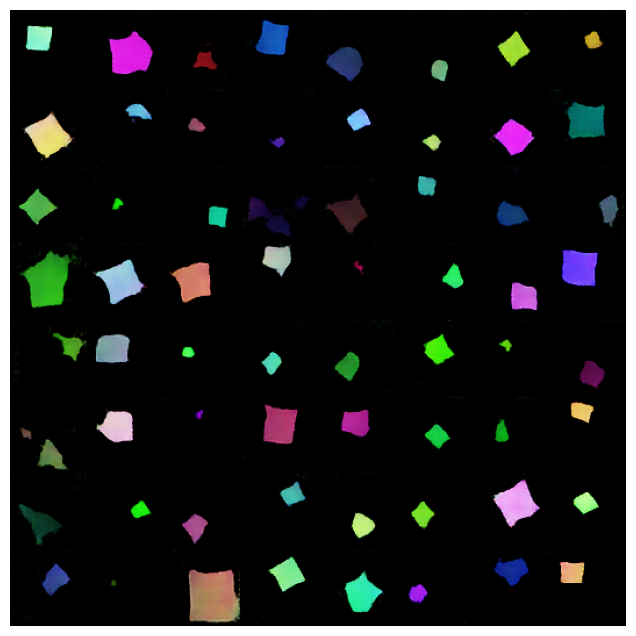

In [16]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

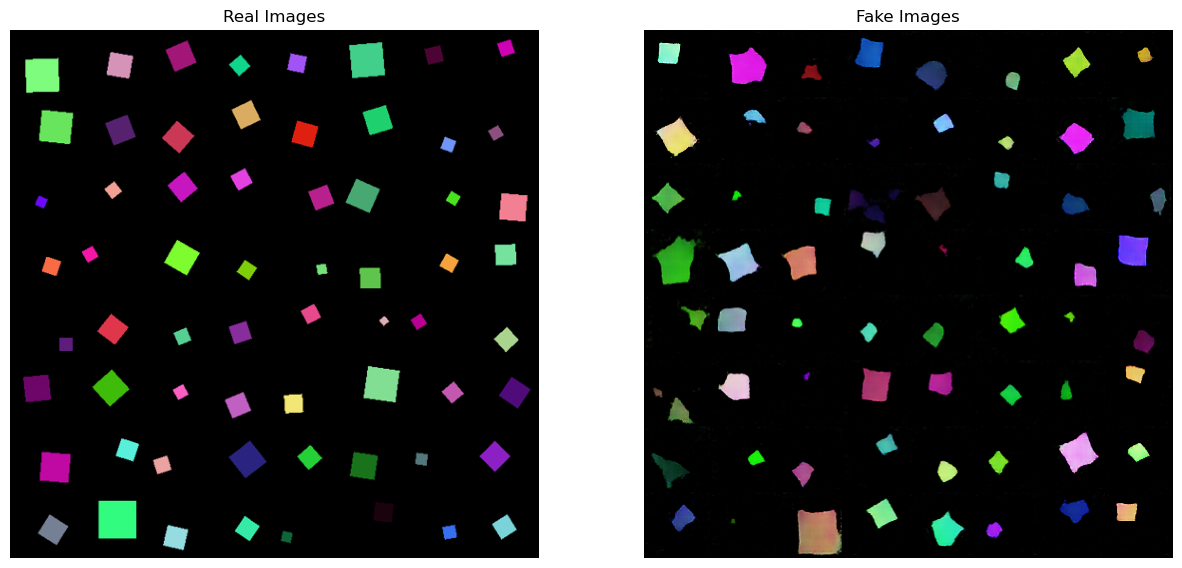

In [17]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()